In [83]:
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn as nn
from src.models.model import MusicNet

In [84]:
# Parameters
config = {
    'seq_length': 50,
    'subset_size': 500000,
    'batch_size': 512,
    'epochs': 50,
    'patience': 5
}

In [85]:
# Load and preprocess data
with open('../data/processed/Bach_all_songs.pkl', 'rb') as f:
    sequences = pickle.load(f)

def process_sequences(sequences, seq_length):
    X, y = [], []
    for sequence in sequences:
        # Filter and extract valid events
        notes = [event['note'] for event in sequence
                 if event['type'] in ['note_on', 'note_off'] and pd.notna(event['note'])]
        # Create input-output pairs
        X.extend([notes[i:i + seq_length] for i in range(len(notes) - seq_length)])
        y.extend([notes[i + seq_length] for i in range(len(notes) - seq_length)])
    return np.array(X), np.array(y)

X, y = process_sequences(sequences, config['seq_length'])
print(f"Processed data shapes: X={X.shape}, y={y.shape}")


Processed data shapes: X=(3517360, 50), y=(3517360,)


In [86]:
# Encode labels
encoder = LabelEncoder()
y = encoder.fit_transform(y)
print(f"Unique classes: {len(encoder.classes_)}")

Unique classes: 87


In [87]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train shapes: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Validation shapes: X_val={X_val.shape}, y_val={y_val.shape}")

Train shapes: X_train=(2813888, 50), y_train=(2813888,)
Validation shapes: X_val=(703472, 50), y_val=(703472,)


In [88]:
# Convert to PyTorch tensors and create DataLoaders
def create_dataloader(X, y, batch_size):
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.long)
    dataset = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

train_loader = create_dataloader(X_train, y_train, config['batch_size'])
val_loader = create_dataloader(X_val, y_val, config['batch_size'])


In [89]:
# Build the model
input_dim = config['seq_length']
output_dim = len(encoder.classes_)
model = MusicNet(input_dim, output_dim)
print(model)

MusicNet(
  (fc1): Linear(in_features=50, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=87, bias=True)
)


In [90]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


Epoch 1/50, Train Loss: 3.7913
Validation Loss: 3.6785
New best model saved to /Users/25lim/Project04_MusicGenerator/src/results/music_model.pth
Epoch 2/50, Train Loss: 3.6649
Validation Loss: 3.6557
New best model saved to /Users/25lim/Project04_MusicGenerator/src/results/music_model.pth
Epoch 3/50, Train Loss: 3.6516
Validation Loss: 3.6450
New best model saved to /Users/25lim/Project04_MusicGenerator/src/results/music_model.pth
Epoch 4/50, Train Loss: 3.6410
Validation Loss: 3.6360
New best model saved to /Users/25lim/Project04_MusicGenerator/src/results/music_model.pth
Epoch 5/50, Train Loss: 3.6316
Validation Loss: 3.6272
New best model saved to /Users/25lim/Project04_MusicGenerator/src/results/music_model.pth
Epoch 6/50, Train Loss: 3.6214
Validation Loss: 3.6158
New best model saved to /Users/25lim/Project04_MusicGenerator/src/results/music_model.pth
Epoch 7/50, Train Loss: 3.6092
Validation Loss: 3.6058
New best model saved to /Users/25lim/Project04_MusicGenerator/src/results/m

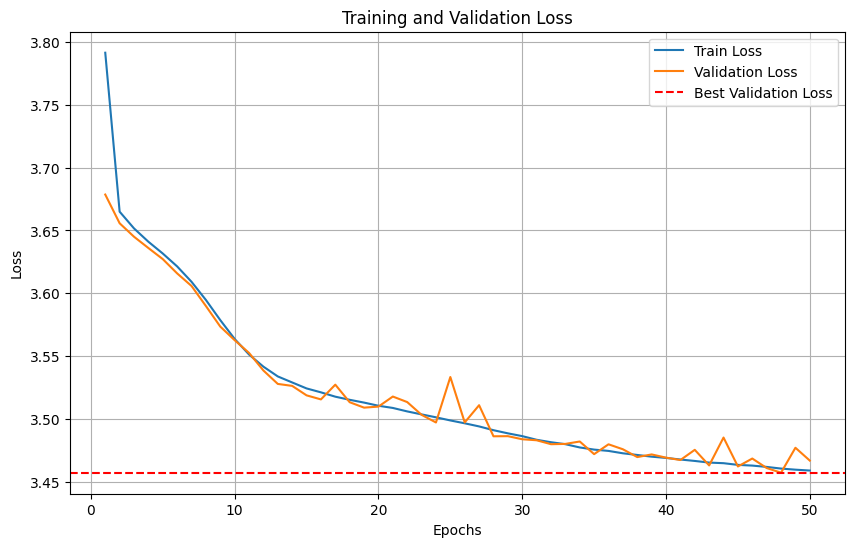

FileNotFoundError: [Errno 2] No such file or directory: '/Users/25lim/Project04_MusicGenerator/src/training/results/loss_plot_v1.png'

<Figure size 640x480 with 0 Axes>

In [91]:
import matplotlib.pyplot as plt

# Initialize lists to store losses
train_losses = []
val_losses = []

# Early stopping variables
best_val_loss = float('inf')
patience_counter = 0
best_model_path = "/Users/25lim/Project04_MusicGenerator/src/results/music_model.pth"

# Training loop
for epoch in range(config['epochs']):
    model.train()
    train_loss = 0

    # Training step
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Record training loss
    train_losses.append(train_loss / len(train_loader))

    # Validation step
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)
    # Reduce learning rate based on validation loss
    scheduler.step(val_loss)


    # Record validation loss
    val_losses.append(val_loss / len(val_loader))

    # Print epoch results
    print(f"Epoch {epoch + 1}/{config['epochs']}, Train Loss: {train_losses[-1]:.4f}")
    print(f"Validation Loss: {val_losses[-1]:.4f}")

    # Early stopping logic
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0  # Reset patience counter
        # Save the best model
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved to {best_model_path}")
    else:
        patience_counter += 1
        print(f"Early stopping patience: {patience_counter}/{config['patience']}")

    if patience_counter >= config['patience']:
        print("Early stopping triggered!")
        break

# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.axhline(y=best_val_loss, color="red", linestyle="--", label="Best Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()

plt.savefig("src/results",dpi=300, bbox_inches="tight")

# Save the final model (if not already saved as the best)
if patience_counter < config['patience']:
    torch.save(model.state_dict(), best_model_path)
    print(f"Final model saved to {best_model_path}")


In [92]:
# Load the best model with weights_only=True
state_dict = torch.load(best_model_path, weights_only=True)
model.load_state_dict(state_dict)
model.eval()

# Evaluate on validation data
val_loss = 0
with torch.no_grad():
    for inputs, targets in val_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        val_loss += loss.item()

print(f"Final Validation Loss of Best Model: {val_loss / len(val_loader):.4f}")


Final Validation Loss of Best Model: 3.4574


In [93]:
sample_input = X_val[:1]  # Take one sequence from validation data
model.eval()
with torch.no_grad():
    output = model(torch.tensor(sample_input, dtype=torch.float32))
    predicted_note = torch.argmax(output, dim=1).item()
print(f"Predicted note: {predicted_note}")


Predicted note: 60


In [94]:
state_dict = torch.load(best_model_path, weights_only=True)
for param_tensor in state_dict:
    print(f"{param_tensor}: {state_dict[param_tensor].size()}")


fc1.weight: torch.Size([128, 50])
fc1.bias: torch.Size([128])
fc2.weight: torch.Size([64, 128])
fc2.bias: torch.Size([64])
fc3.weight: torch.Size([87, 64])
fc3.bias: torch.Size([87])
